In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from scipy import stats

import lightgbm as lgb
from catboost import CatBoostRegressor

import matplotlib.pylab as plt
plt.style.use('ggplot')


In [2]:
scaling_factor = 1000000000000

In [3]:
train_apartment = pd.read_csv('../data/apartments_train.csv')
train_building = pd.read_csv('../data/buildings_train.csv')
train = pd.merge(train_apartment, train_building, left_on='building_id', right_on='id')
train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
train.drop('id_y', axis=1, inplace=True)
# Remove duplicate column after merge.

In [4]:
test_apartment = pd.read_csv('../data/apartments_test.csv')
test_building = pd.read_csv('../data/buildings_test.csv')
print('app length', len(test_apartment))
print('buildings length', len(test_building))
test = pd.merge(test_apartment, test_building, left_on='building_id', right_on='id')
print('merged length', len(test))
test.rename(columns={'id_x' : 'id'}, inplace=True)
test.drop('id_y', axis=1, inplace=True)
test = test.drop(['street', 'address'], axis=1)


app length 9937
buildings length 2931
merged length 9937


In [44]:
test_apartment

,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,1.0,5148
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,NaN,1.0,0.0,NaN,NaN,3.0,1.0,1290
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,0.0,1.0,0.0,NaN,NaN,NaN,1.0,681
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,4261
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,7530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9932,33217,3.0,106.0,19.9,56.7,16.0,3.0,NaN,3.30,NaN,NaN,NaN,NaN,0.0,1.0,NaN,1.0,4252
9933,33218,NaN,82.0,NaN,NaN,3.0,3.0,NaN,NaN,2.0,0.0,1.0,0.0,NaN,NaN,1.0,2.0,7380
9934,33219,NaN,49.3,NaN,NaN,15.0,1.0,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1480
9935,33220,NaN,38.8,10.5,15.1,14.0,1.0,NaN,3.30,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2154


In [5]:
column_names_apartments = ['apartment_id', 'seller', 'area_total', 'area_kitchen', 'area_living',
       'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared',
       'bathrooms_private', 'windows_court', 'windows_street', 'balconies',
       'loggias', 'condition', 'phones', 'building_id', 'price']
column_names_buildings = ['new', 'latitude', 'longitude', 'district', 'street', 'address',
       'constructed', 'material', 'stories', 'elevator_without',
       'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute',
       'heating']
all_features = column_names_apartments[:-1] + column_names_buildings
#features selected based on gini importance in LGBM model in sequential_all_data
selected_features = ['area_total','area_kitchen','floor','bathrooms_private','longitude','latitude','district','constructed','stories']

In [6]:
def preprocess(data,price_outlier_rejection=False,fill=True):
    if price_outlier_rejection is True:
        data = data[(np.abs(stats.zscore(data['price'])) < 3.9)]
    if fill is True:
        return data.fillna(data.mean())
    else:
        return data.dropna()

In [7]:
processed_data = preprocess(train)

In [8]:
processed_test = preprocess(test)
processed_test = processed_test[selected_features]

In [9]:
X = processed_data[selected_features]
y = processed_data['price']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Adaboost

In [11]:
adaboost = AdaBoostRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    loss='square',
    random_state=42
)

In [12]:
adaboost.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.05, loss='square', n_estimators=1500,
                  random_state=42)

In [13]:
ada_prediction = adaboost.predict(X_test)

In [14]:
ada_mse = round(mean_squared_error(ada_prediction, y_test), 2)
print('Test MSE:', ada_mse/scaling_factor)

Test MSE: 5989.747843801746


Text(0, 0.5, 'Ground Truth')

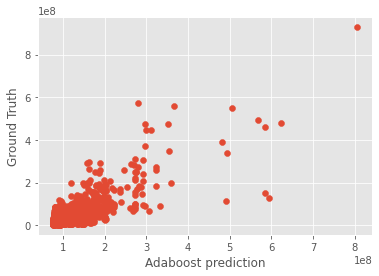

In [15]:
plt.scatter(ada_prediction, y_test)
plt.xlabel('Adaboost prediction')
plt.ylabel('Ground Truth')

# Gradient Boosting Machine

In [16]:
grad_boost_regr = GradientBoostingRegressor(
    learning_rate=0.01,
    n_estimators=2000,
    subsample=1.0, 
    criterion='mse', 
    min_samples_split=4, 
    min_samples_leaf=2, 
    min_weight_fraction_leaf=0.0, 
    max_depth=9, 
    min_impurity_decrease=0.0, 
    init=None, 
    random_state=0, 
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0
)

In [17]:
grad_boost_regr.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.01, max_depth=9,
                          min_samples_leaf=2, min_samples_split=4,
                          n_estimators=2000, random_state=0)

In [18]:
gb_prediction = grad_boost_regr.predict(X_test)

In [19]:
gb_mse = round(mean_squared_error(gb_prediction, y_test), 2)
print('Test MSE:', gb_mse/scaling_factor)

Test MSE: 248.97338429524638


Text(0, 0.5, 'Ground Truth')

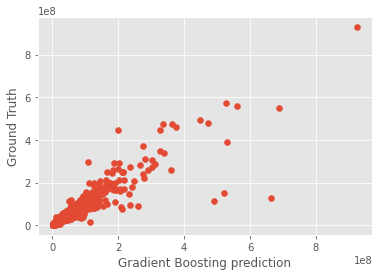

In [20]:
plt.scatter(gb_prediction, y_test)
plt.xlabel('Gradient Boosting prediction')
plt.ylabel('Ground Truth')

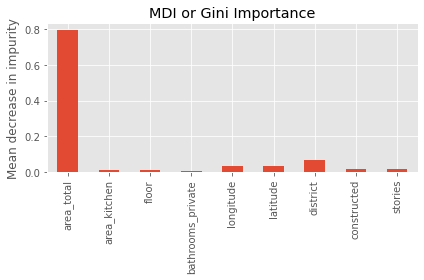

In [21]:
importances = grad_boost_regr.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("MDI or Gini Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# LightGBM

In [22]:
light_gbm = lgb.LGBMRegressor(
    num_leaves=10,
    max_depth=5, 
    random_state=42, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=2000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
)

In [23]:
light_gbm.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.95, learning_rate=0.05, max_depth=5,
              metric='mse', n_estimators=2000, n_jobs=4, num_leaves=10,
              random_state=42, subsample=0.9)

In [24]:
lgbm_prediction = light_gbm.predict(X_test)

In [25]:
lgb_mse = round(mean_squared_error(lgbm_prediction, y_test), 2)
print('Test MSE:', lgb_mse/scaling_factor)

Test MSE: 361.60272153453536


Text(0, 0.5, 'Ground Truth')

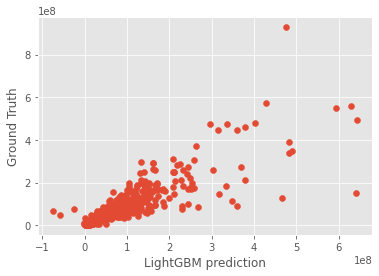

In [26]:
plt.scatter(lgbm_prediction, y_test)
plt.xlabel('LightGBM prediction')
plt.ylabel('Ground Truth')

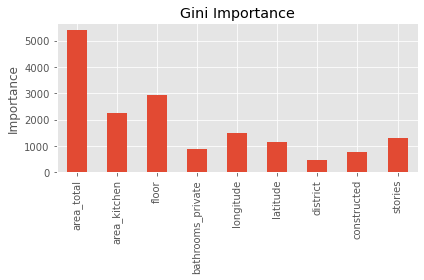

In [27]:
importances = light_gbm.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# CatBoost

In [28]:
model6 = CatBoostRegressor(
    n_estimators=500,
    learning_rate=0.1,
    thread_count=-1,
    depth=7,
    silent=True,
    random_seed=42,
    bagging_temperature=0.2
#     od_type="Iter"
)

In [29]:
model6.fit(X_train, y_train)

In [30]:
cat_prediction = model6.predict(X_test)

In [31]:
cat_mse = round(mean_squared_error(cat_prediction, y_test), 2)
print('Test MSE:', cat_mse/scaling_factor)

Test MSE: 351.7503284990915


Text(0, 0.5, 'Ground Truth')

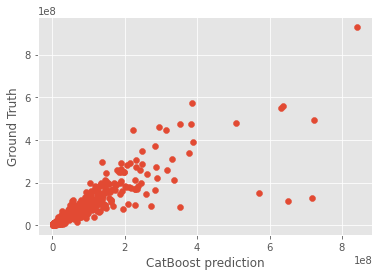

In [32]:
plt.scatter(cat_prediction, y_test)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')

# Try gradient boost to obtain submission

In [33]:
grad_boost_regr.fit(X, y)

GradientBoostingRegressor(criterion='mse', learning_rate=0.01, max_depth=9,
                          min_samples_leaf=2, min_samples_split=4,
                          n_estimators=2000, random_state=0)

In [34]:
gb_prediction = grad_boost_regr.predict(processed_test)

In [35]:
gb_prediction

array([32168105.21436077, 31352111.7233562 , 51327479.2859403 , ...,
        8785657.97231116, 12409244.91126426,  7429545.27876493])

In [36]:
print(len(gb_prediction))
print(len(test))

9937
9937


In [45]:
df = pd.DataFrame(gb_prediction, columns = ['price_prediction'])

In [46]:
df

,price_prediction
0,3.216811e+07
1,3.135211e+07
2,5.132748e+07
3,2.012628e+07
4,1.998989e+07
...,...
9932,4.503917e+06
9933,1.053431e+07
9934,8.785658e+06
9935,1.240924e+07


In [47]:
result = pd.concat([test['id'], df], axis=1)

In [48]:
result

,id,price_prediction
0,23285,3.216811e+07
1,23850,3.135211e+07
2,24470,5.132748e+07
3,24563,2.012628e+07
4,24564,1.998989e+07
...,...,...
9932,33150,4.503917e+06
9933,33153,1.053431e+07
9934,33163,8.785658e+06
9935,33208,1.240924e+07


In [52]:
result[['id','price_prediction']].to_csv('submission.csv', index=False)